In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import date
import calendar
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import copy
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv("MELBOURNE_HOUSE_PRICES_LESS.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63023 entries, 0 to 63022
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         63023 non-null  object 
 1   Address        63023 non-null  object 
 2   Rooms          63023 non-null  int64  
 3   Type           63023 non-null  object 
 4   Price          48433 non-null  float64
 5   Method         63023 non-null  object 
 6   SellerG        63023 non-null  object 
 7   Date           63023 non-null  object 
 8   Postcode       63023 non-null  int64  
 9   Regionname     63023 non-null  object 
 10  Propertycount  63023 non-null  int64  
 11  Distance       63023 non-null  float64
 12  CouncilArea    63023 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 6.3+ MB


***Notes:

Suburb: Name of the area

Rooms: Number of rooms

Type: Property's type (house, duplex, etc.)

Method: Property's selling method

SellerG: Real Estate agent's name

Date: Date sold

Distance: Distance from the city centre (CBD)

In [5]:
df.head(5)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
0,Abbotsford,49 Lithgow St,3,h,1490000.0,S,Jellis,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
1,Abbotsford,59A Turner St,3,h,1220000.0,S,Marshall,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
2,Abbotsford,119B Yarra St,3,h,1420000.0,S,Nelson,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
3,Aberfeldie,68 Vida St,3,h,1515000.0,S,Barry,1/04/2017,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council
4,Airport West,92 Clydesdale Rd,2,h,670000.0,S,Nelson,1/04/2017,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council


In [6]:
df.shape

(63023, 13)

Our dataset originally has 13 features and around 63 thounsands observations

In [7]:
pd.isnull(df).sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price            14590
Method               0
SellerG              0
Date                 0
Postcode             0
Regionname           0
Propertycount        0
Distance             0
CouncilArea          0
dtype: int64

There are 14590 observations that have missing value for 'price' feature which is target variable.

Since 'Price' is our target variable, it's considerable to delete those observations without corresponding price.

In [8]:
df.dropna(subset = ['Price'], inplace = True)

In [9]:
df.shape

(48433, 13)

In [10]:
df.describe()

,Rooms,Price,Postcode,Propertycount,Distance
count,48433.000000,4.843300e+04,48433.000000,48433.000000,48433.000000
mean,3.071666,9.978982e+05,3123.210332,7566.399913,12.702761
std,0.944708,5.934989e+05,125.534940,4457.405884,7.550030
min,1.000000,8.500000e+04,3000.000000,39.000000,0.000000
25%,2.000000,6.200000e+05,3051.000000,4280.000000,7.000000
50%,3.000000,8.300000e+05,3103.000000,6567.000000,11.700000
75%,4.000000,1.220000e+06,3163.000000,10412.000000,16.700000
max,31.000000,1.120000e+07,3980.000000,21650.000000,55.800000


In [11]:
df.describe(include = 'O')

,Suburb,Address,Type,Method,SellerG,Date,Regionname,CouncilArea
count,48433,48433,48433,48433,48433,48433,48433,48433
unique,370,44739,3,5,422,112,8,34
top,Reservoir,14 Moray St,h,S,Barry,24/03/2018,Northern Metropolitan,Darebin City Council
freq,1067,7,34161,30624,4818,880,13598,3462


Suburb, Adress and SellerG features all have too many unique values.

We can either get rid of them or make some preprocessing before consider taking them into our model later.

### EDA: categorical variables

#### 1. Council Area:

In [12]:
df['CouncilArea'].value_counts().reset_index().shape

(34, 2)

There are 34 unique council areas in the dataset

In [13]:
ca = df.groupby(['CouncilArea']).size().reset_index(name = 'num_houses')
ca.sort_values(by=['num_houses'], inplace=True, ascending = False)

In [14]:
ca.head(10)

,CouncilArea,num_houses
6,Darebin City Council,3462
2,Boroondara City Council,3455
0,Banyule City Council,2902
3,Brimbank City Council,2720
24,Moreland City Council,2519
1,Bayside City Council,2495
21,Monash City Council,2442
11,Hume City Council,2373
8,Glen Eira City Council,2351
22,Moonee Valley City Council,2163


Text(0, 0.5, 'Housing price')

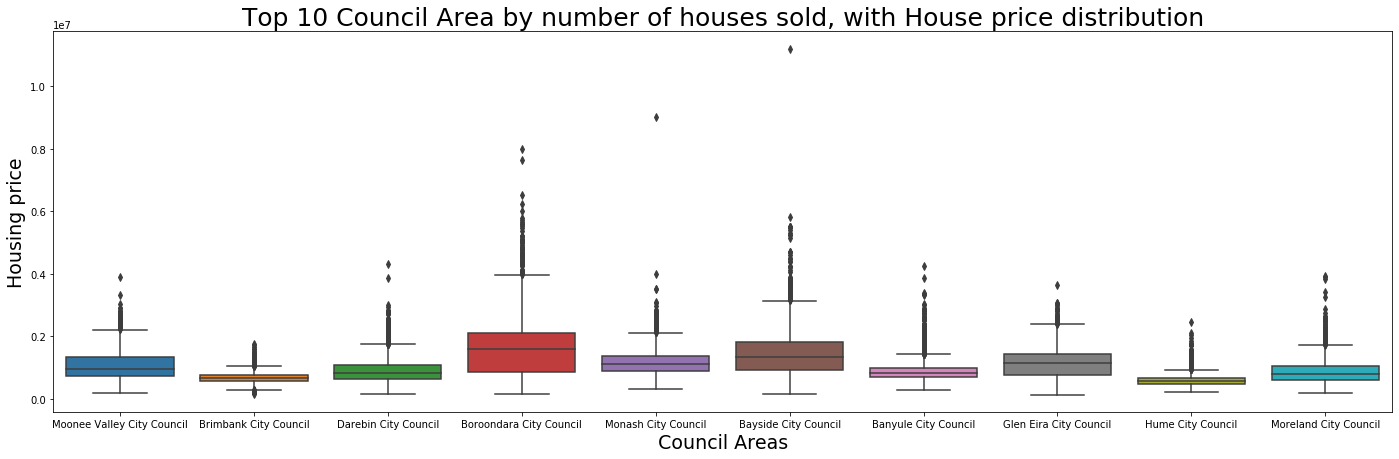

In [15]:
plt.figure(figsize = (24,7))
sns.boxplot(data = df[df['CouncilArea'].isin(ca['CouncilArea'].head(10))],x = 'CouncilArea', y = 'Price')
plt.title('Top 10 Council Area by number of houses sold, with House price distribution',fontsize = 25)
plt.xlabel("Council Areas",fontsize = 19)
plt.ylabel("Housing price",fontsize = 19)

Hypothesis testing for 'Council Area' variable

<b><u>Test 1:</u></b>
    
    pop 1: Housing price in Darebin City Council
    pop 2: Housing price in Boroondara City Council
    pop 3: Housing price in Banyule City Council
    pop 4: Housing price in other council areas

- H0: There is no significant difference in housing price amongst council areas.
- H1: There is a significant difference in housing price amongst council areas.

In [16]:
fvalue, pvalue = stats.f_oneway(df[df['CouncilArea'] == 'Darebin City Council']['Price'],
                               df[df['CouncilArea'] == 'Boroondara City Council']['Price'],
                                df[df['CouncilArea'] == 'Banyule City Council']['Price'],
                                df[~df['CouncilArea'].isin(['Darebin City Council','Boroondara City Council','Banyule City Council'])]['Price']
                               )

print(f"Results of ANOVA test:\n The F-statistic is: {fvalue}\n The p-value is: {pvalue}")

Results of ANOVA test:
 The F-statistic is: 1628.4236386389923
 The p-value is: 0.0


Conclusion: Since p-value < 0.05, there is a significant difference in housing price amongst council areas.

<i> We will keep 'Council Area' variable for our modeling stage after EDA section. </i>

#### 2. Region name

In [17]:
df['Regionname'].value_counts().reset_index().shape

(8, 2)

There are 8 unique region names in the dataset

In [18]:
rn = df.groupby(['Regionname']).size().reset_index(name = 'num_houses')
rn.sort_values(by=['num_houses'], inplace=True, ascending = False)

In [19]:
rn.head(8)

,Regionname,num_houses
2,Northern Metropolitan,13598
5,Southern Metropolitan,12549
6,Western Metropolitan,9680
0,Eastern Metropolitan,7585
4,South-Eastern Metropolitan,4010
3,Northern Victoria,455
1,Eastern Victoria,374
7,Western Victoria,182


Text(0, 0.5, 'Housing price')

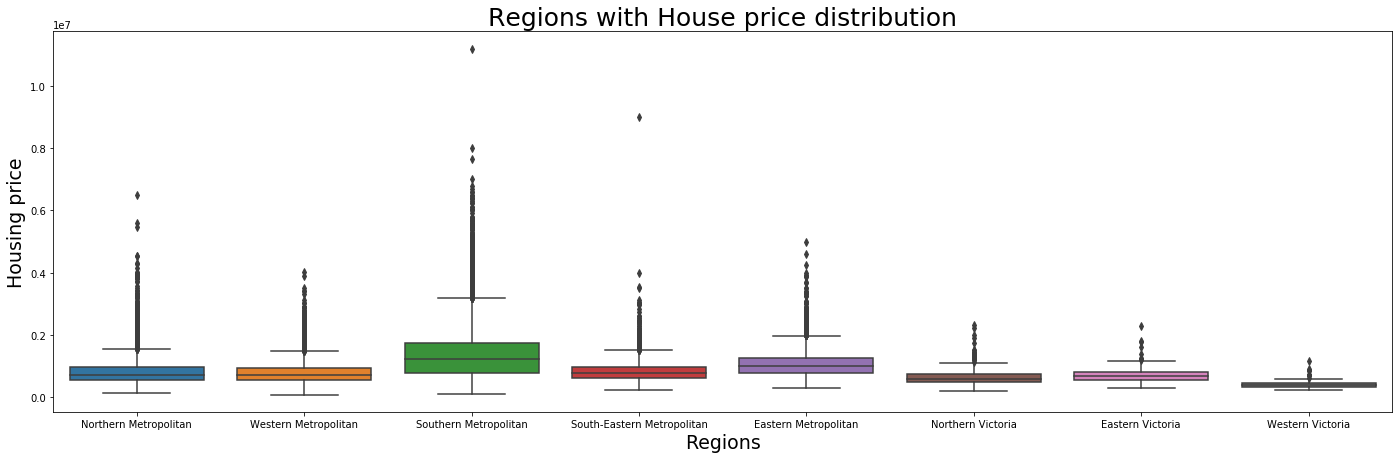

In [20]:
plt.figure(figsize = (24,7))
sns.boxplot(data = df[df['Regionname'].isin(rn['Regionname'].head(10))],x = 'Regionname', y = 'Price')
plt.title('Regions with House price distribution',fontsize = 25)
plt.xlabel("Regions",fontsize = 19)
plt.ylabel("Housing price",fontsize = 19)

Hypothesis testing for 'Region' variable

<b><u>Test 2:</u></b>
    
    pop 1: Housing price in Northern Metropolitan region
    pop 2: Housing price in Southern Metropolitan region
    pop 3: Housing price in other regions

- H0: There is no significant difference in housing price amongst regions.
- H1: There is a significant difference in housing price amongst regions.

In [21]:
fvalue, pvalue = stats.f_oneway(df[df['Regionname'] == 'Northern Metropolitan']['Price'],
                               df[df['Regionname'] == 'Southern Metropolitan']['Price'],
#                                 df[df['Regionname'] == 'Western Metropolitan']['Price'],
                                df[~df['Regionname'].isin(['Northern Metropolitan','Southern Metropolitan'])]['Price']
                               )

print(f"Results of ANOVA test:\n The F-statistic is: {fvalue}\n The p-value is: {pvalue}")

Results of ANOVA test:
 The F-statistic is: 4014.9544600232443
 The p-value is: 0.0


Conclusion: Since p-value < 0.05, there is a significant difference in housing price amongst council areas.

<i> We will keep 'Regionname' variable for our modeling stage after EDA section. </i>

#### 3. Real Estate Agent (SellerG)

In [22]:
df['SellerG'].value_counts()

Barry                      4818
Jellis                     4088
Nelson                     4008
Ray                        3653
hockingstuart              3465
                           ... 
hockingstuart/Advantage       1
Auv                           1
Shine                         1
Woodards/hockingstuart        1
iProperty                     1
Name: SellerG, Length: 422, dtype: int64

There are 422 different middle-men, some of them only have 1 done deal, others have thousands of houses sold.

In [23]:
seller = df.groupby('SellerG').size().reset_index(name = 'num_houses')
seller.sort_values(by=['num_houses'], inplace=True, ascending = False)
seller.head()

,SellerG,num_houses
28,Barry,4818
180,Jellis,4088
253,Nelson,4008
308,Ray,3653
403,hockingstuart,3465


In [24]:
seller[seller['num_houses'] < 10].groupby('num_houses').size().reset_index(name = 'num_sellers')

,num_houses,num_sellers
0,1,113
1,2,45
2,3,25
3,4,16
4,5,16
5,6,15
6,7,8
7,8,3
8,9,5


In [25]:
# Avg number of houses sold of each seller
seller['num_houses'].mean()

114.77014218009478

In [26]:
seller[seller['num_houses'] >= 115].groupby('num_houses').size().reset_index(name = 'num_sellers').shape

(48, 2)

***More than 200 sellers have number of houses sold < 10***

Create new variable: ***seller_size**: to distinguish seller types.

    Big sellers: who has number of houses sold >= 3rd Quartile

    SM sellers: who has number of houses sold < 3rd Quartile

In [27]:
Q1,Q3 = np.percentile(sorted(seller['num_houses']),[25,75])

In [28]:
#Create big_seller varible for 'seller' dataframe

seller['big_seller'] = seller['num_houses'].apply(lambda x: 1 if x>= Q3 else 0)

In [29]:
#Create dictionary containing seller name and type
dictseller = seller.drop(['num_houses'], axis=1).set_index('SellerG').T.to_dict('records')
dictseller  = dictseller[0]

In [30]:
#Create big_seller varibale for our main data frame
df['big_seller'] = df['SellerG'].apply(lambda x: dictseller[x])

In [31]:
df.drop(columns = 'SellerG',inplace = True)

In [32]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea,big_seller
0,Abbotsford,49 Lithgow St,3,h,1490000.0,S,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council,1
1,Abbotsford,59A Turner St,3,h,1220000.0,S,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council,1
2,Abbotsford,119B Yarra St,3,h,1420000.0,S,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council,1
3,Aberfeldie,68 Vida St,3,h,1515000.0,S,1/04/2017,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council,1
4,Airport West,92 Clydesdale Rd,2,h,670000.0,S,1/04/2017,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council,1


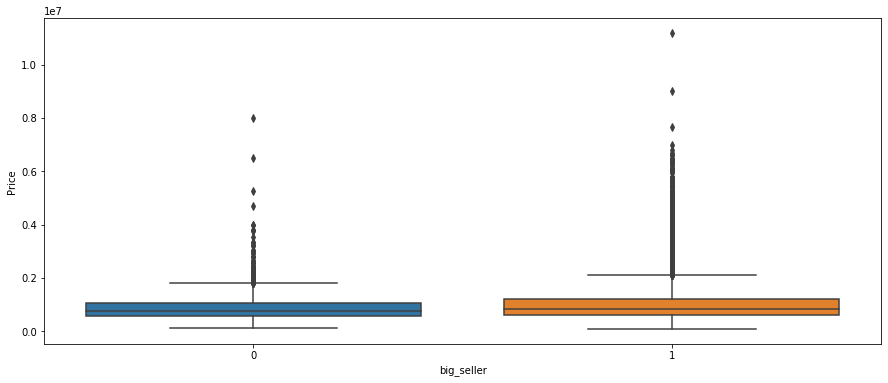

In [33]:
plt.figure(figsize = (15,6))
sns.boxplot(data = df,x = 'big_seller', y = 'Price')

From the box plots, we can sense a slight difference between 2 seller types.

We will have to do a hypothesis testing to make sure our intuition is correct.

Hypothesis testing for Seller's type variable

<b><u>Test 3:</u></b>
    
    pop 1: Housing price by big sellers
    pop 2: Housing price by small and medium sellers

- H0: There is no significant difference in housing price between big sellers group and the other group
- H1: There is a significant difference in housing price between big sellers group and the other group

In [34]:
fvalue, pvalue = stats.f_oneway(df[df['big_seller'] == 1]['Price'],
                               df[df['big_seller'] == 0]['Price'])

print(f"Results of ANOVA test:\n The F-statistic is: {fvalue}\n The p-value is: {pvalue}")

Results of ANOVA test:
 The F-statistic is: 53.8107964094991
 The p-value is: 2.2420170532952392e-13


<u> Conclusion:</u> From the test, we have p_value < 0.05 and the F-statistics > 0, we can expect the houses which were sold by big seller tend to have high evaluation in term of price.

####  <i> We will keep 'big_seller' variable for our modeling stage after EDA section. </i>

#### 4. Types of house

In [35]:
df.groupby('Type').size().reset_index(name = 'num_houses').sort_values(by = 'num_houses', ascending = False)

,Type,num_houses
0,h,34161
2,u,9292
1,t,4980


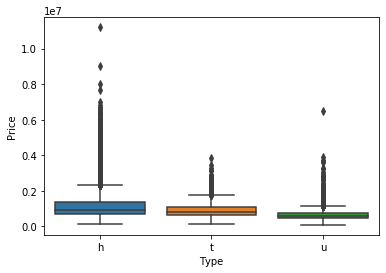

In [36]:
sns.boxplot(data = df, x = 'Type',y = 'Price')

In [37]:
fvalue, pvalue = stats.f_oneway(df[df['Type'] == 'h']['Price'],
                                df[df['Type'] == 't']['Price'],
                               df[df['Type'] == 'u']['Price'])

print(f"Results of ANOVA test:\n The F-statistic is: {fvalue}\n The p-value is: {pvalue}")

Results of ANOVA test:
 The F-statistic is: 2729.5989180045585
 The p-value is: 0.0


<u> Conclusion:</u> From the test, we have p_value < 0.05, we can expect the type of house can have a significant impact on the price.

#### 5. Selling methods

In [38]:
df.groupby('Method').size().reset_index(name = 'num_houses').sort_values(by = 'num_houses',ascending = False)

,Method,num_houses
1,S,30624
3,SP,6480
0,PI,5940
4,VB,5024
2,SA,365


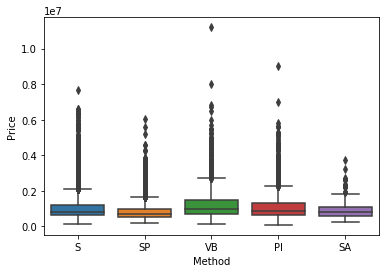

In [39]:
sns.boxplot(data = df, x = 'Method', y = 'Price')

In [40]:
fvalue, pvalue = stats.f_oneway(df[df['Method'] == 'S']['Price'],
                                df[df['Method'] == 'SP']['Price'],
                                df[df['Method'] == 'VB']['Price'],
                                df[df['Method'] == 'PI']['Price'],
                               df[df['Method'] == 'SA']['Price'])

print(f"Results of ANOVA test:\n The F-statistic is: {fvalue}\n The p-value is: {pvalue}")

Results of ANOVA test:
 The F-statistic is: 258.7243651701805
 The p-value is: 2.2279760228635492e-220


<u> Conclusion:</u> From the test, we have p_value < 0.05 and the F-statistics > 0, we can expect the houses' selling methods can have a significant impact on the price.

#### 6. Date

In [41]:
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

In [42]:
df['Month'] = df['Date'].dt.month

In [43]:
df['Month'].value_counts()

5     5719
9     5516
6     4681
4     4417
11    4353
10    4245
8     4153
12    3909
3     3835
7     3772
2     2552
1     1281
Name: Month, dtype: int64

Text(0.5, 0, 'Month')

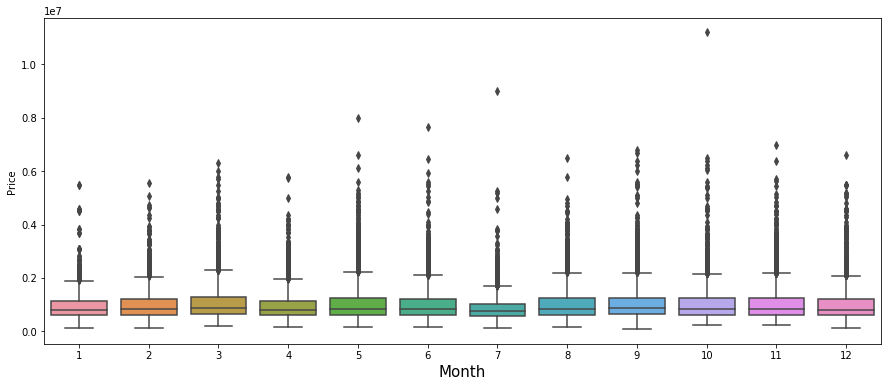

In [44]:
plt.figure(figsize = (15,6))
sns.boxplot(data = df, x = 'Month', y = 'Price')
plt.xlabel('Month',fontsize = 15)

In [45]:
df['quarter'] = df['Date'].dt.quarter

Text(0.5, 0, 'Quarters')

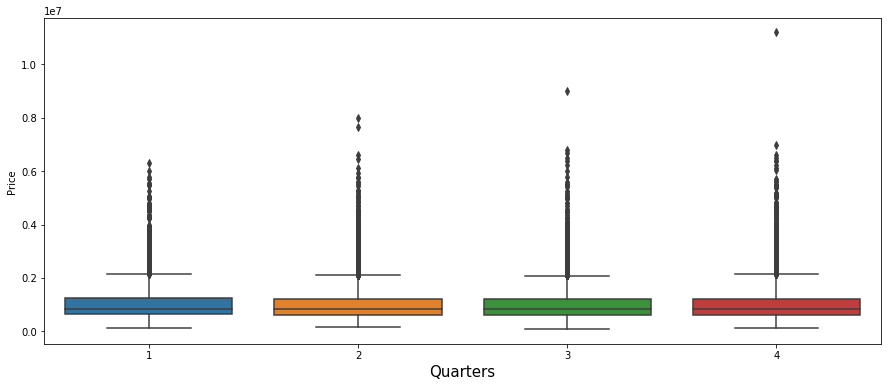

In [46]:
plt.figure(figsize = (15,6))
sns.boxplot(data = df, x = 'quarter',y = 'Price')
plt.xlabel('Quarters',fontsize = 15)

In [47]:
fvalue, pvalue = stats.f_oneway(df[df['quarter'] == 1]['Price'],
                                df[df['quarter'] == 2]['Price'],
                                df[df['quarter'] == 3]['Price'],
                               df[df['quarter'] == 4]['Price'])

print(f"Results of ANOVA test:\n The F-statistic is: {fvalue}\n The p-value is: {pvalue}")

Results of ANOVA test:
 The F-statistic is: 6.648166074492652
 The p-value is: 0.00017462243579350524


<u> Conclusion:</u> From the test, we have p_value < 0.05, we can expect months and the quarters in which the house was sold can have significant impact on its price.

####  <i> We will keep 'quarters' and 'months' variables for our modeling stage after EDA section. </i>

For the last two features: 'Suburb' and 'Address', consider not taking these two features into the model.

For Suburb we already have a numeric feature to represent it, which is 'Propertycount'

'Address' also seems tobe represented by other geographic features including Region name and council area.

In [48]:
df.drop(columns = ['Address','Suburb'],inplace = True)

### Examinate numerical features:

In [49]:
df.describe()

,Rooms,Price,Postcode,Propertycount,Distance,big_seller,Month,quarter
count,48433.000000,4.843300e+04,48433.000000,48433.000000,48433.000000,48433.000000,48433.000000,48433.000000
mean,3.071666,9.978982e+05,3123.210332,7566.399913,12.702761,0.961947,6.994239,2.635662
std,0.944708,5.934989e+05,125.534940,4457.405884,7.550030,0.191325,3.116434,1.031856
min,1.000000,8.500000e+04,3000.000000,39.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,6.200000e+05,3051.000000,4280.000000,7.000000,1.000000,5.000000,2.000000
50%,3.000000,8.300000e+05,3103.000000,6567.000000,11.700000,1.000000,7.000000,3.000000
75%,4.000000,1.220000e+06,3163.000000,10412.000000,16.700000,1.000000,10.000000,4.000000
max,31.000000,1.120000e+07,3980.000000,21650.000000,55.800000,1.000000,12.000000,4.000000


Text(0.5, 1, 'Correlation hearmap')

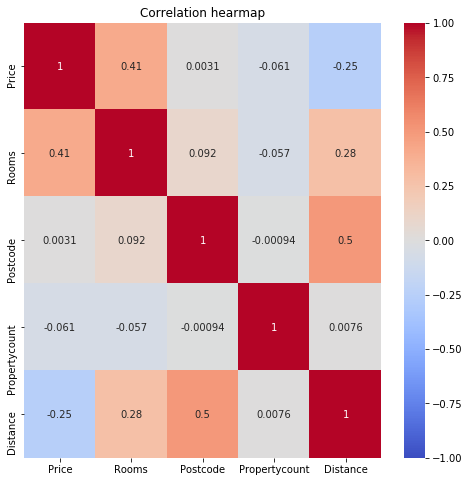

In [50]:
plt.figure(figsize = (8,8))
corrdf = df[['Price','Rooms','Postcode','Propertycount','Distance']].corr()
ax = sns.heatmap(data = corrdf, cmap ="coolwarm", annot = True,vmin=1, vmax=-1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Correlation hearmap')

Postcode feature seems to have a very weak impact on house's price as expected.

It's reasonable to not include this feature into our regression model.

In [51]:
df.drop(columns = 'Postcode',inplace = True)

#### 1. Distance to city center CBD

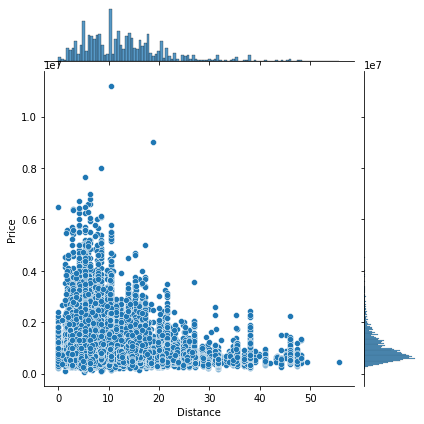

In [52]:
sns.jointplot(data = df, x = 'Distance', y= 'Price')

Despite the appearences after some special cases, the distance to city centre has a considerable impact on Price.

We can see as the distance increase the overall housing price decreses.

#### 2. Number of rooms

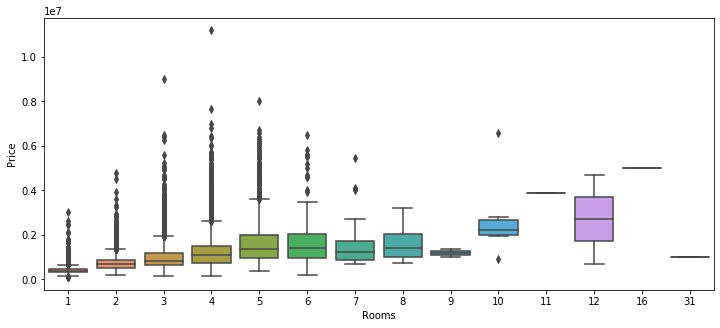

In [53]:
plt.figure(figsize = (12,5))
sns.boxplot(data = df, x = 'Rooms',y = 'Price')

From the above plot, there seems to be a increasing in price as the number of rooms increases.

In [54]:
df['Rooms'].value_counts()

3     21812
4     11576
2     10674
5      2350
1      1670
6       283
7        36
8        19
10        6
12        2
9         2
31        1
16        1
11        1
Name: Rooms, dtype: int64

In [55]:
#Delete observations with unusual number of rooms
df = df[df['Rooms'] <= 10]

## Target variable: PRICE

### 1. Distribution:

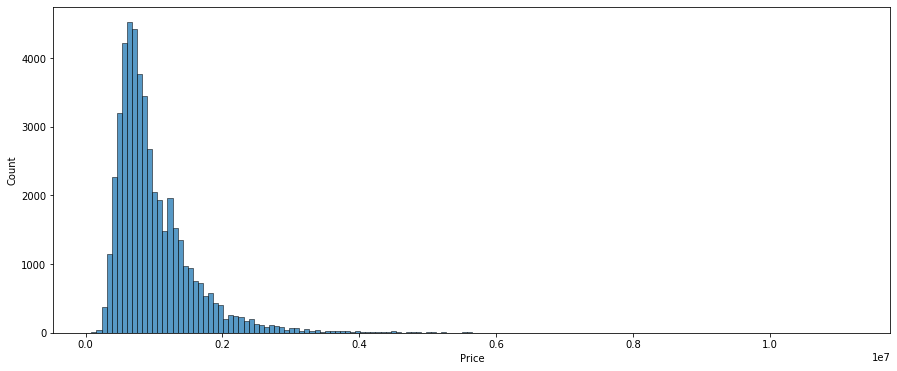

In [56]:
plt.figure(figsize = (15,6))
sns.histplot(x = df['Price'], bins = 150)

Price variable of the dataset seems to have a right-skewed distribution. (Mean > Median)

In [57]:
#### Eliminate outliers from 'Price' using IQR

Q1,Q3 = np.percentile(sorted(df['Price']),[25,75])
IQR = Q3 - Q1
upperlim = Q3 + 1.5*IQR
lowerlim = max(Q1 - 1.5*IQR,0)

print(Q1)
print(Q3)
print(IQR)
print(upperlim)
print(lowerlim)

620000.0
1220000.0
600000.0
2120000.0
0


In [58]:
df[(df['Price'] < lowerlim) | (df['Price'] > upperlim)].shape

(2269, 12)

There are 2269 observations considered as outliers in our dataset.

In [59]:
df.drop(df[(df['Price'] < lowerlim) | (df['Price'] > upperlim)].index,inplace = True)

In [60]:
df.shape

(46159, 12)

In [61]:
print(df.shape)
print(df.dropna().shape)

(46159, 12)
(46159, 12)


## Linear Regression model

In [62]:
df.columns

Index(['Rooms', 'Type', 'Price', 'Method', 'Date', 'Regionname',
       'Propertycount', 'Distance', 'CouncilArea', 'big_seller', 'Month',
       'quarter'],
      dtype='object')

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46159 entries, 0 to 63020
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Rooms          46159 non-null  int64         
 1   Type           46159 non-null  object        
 2   Price          46159 non-null  float64       
 3   Method         46159 non-null  object        
 4   Date           46159 non-null  datetime64[ns]
 5   Regionname     46159 non-null  object        
 6   Propertycount  46159 non-null  int64         
 7   Distance       46159 non-null  float64       
 8   CouncilArea    46159 non-null  object        
 9   big_seller     46159 non-null  int64         
 10  Month          46159 non-null  int64         
 11  quarter        46159 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 4.6+ MB


In [64]:
df.drop(columns = 'Date',inplace = True)

In [65]:
df.drop(columns = 'Propertycount',inplace = True)

In [66]:
categorical_features = ['Type','Method','Regionname','CouncilArea','big_seller','Month','quarter']

In [67]:
df = pd.get_dummies(data = df, columns = categorical_features, drop_first = True)

I was using get_dummies from pandas, but we can use one_hot encoder for the time.

In [68]:
df.shape

(46159, 64)

In [69]:
df.head(2)

,Rooms,Price,Distance,Type_t,Type_u,Method_S,Method_SA,Method_SP,Method_VB,Regionname_Eastern Victoria,...,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,quarter_2,quarter_3,quarter_4
0,3,1490000.0,3.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,3,1220000.0,3.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## I. Using Sklearn-LinearRegression: (Ordinary Least Squares Linear Regression)

Using the following equation to estimate the parameters

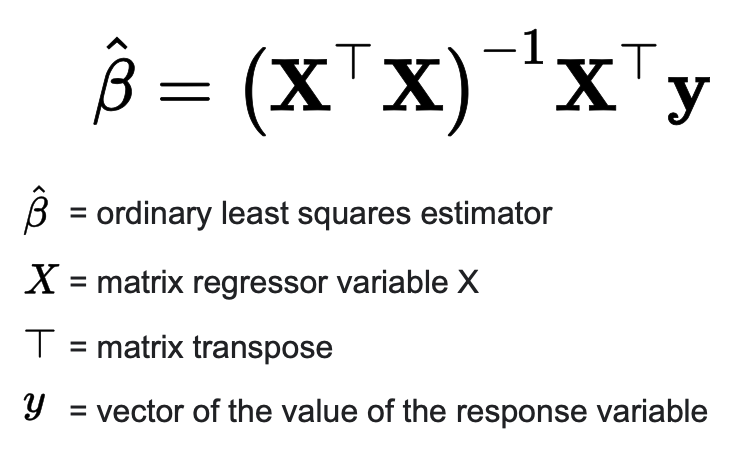

### 1. Without PCA:

1.1. Holdout

In [70]:
linreg_ho = LinearRegression()

In [71]:
#We will split the dataset into 5 parts, one of them is testing set.
train,test = train_test_split(df, test_size = 0.2, random_state = 1)

In [72]:
print(train.shape)
print(test.shape)

(36927, 64)
(9232, 64)


In [73]:
X_train = train.loc[:,~df.columns.isin(['Price'])]
y_train = train['Price']

In [74]:
X_train.shape

(36927, 63)

In [75]:
X_test = test.loc[:,~df.columns.isin(['Price','Price_log'])]
y_test = test['Price']

In [76]:
print(X_test.shape)

(9232, 63)


In [77]:
X_train[:5]

,Rooms,Distance,Type_t,Type_u,Method_S,Method_SA,Method_SP,Method_VB,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,...,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,quarter_2,quarter_3,quarter_4
51703,4,14.0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1
44728,4,13.8,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
11586,4,10.5,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
60311,4,24.7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
62184,3,12.9,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [78]:
linreg_ho.fit(X_train.values,y_train.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [79]:
predict_y_train = linreg_ho.predict(X_train)

print('Train set score: MSE = ', mean_squared_error(y_train,predict_y_train))
print('Train set score: R squared = ', r2_score(y_train,predict_y_train))

print('')

predict_y_test = linreg_ho.predict(X_test)
print('Test set score: MSE = ', mean_squared_error(y_test,predict_y_test))
print('Test set score: R squared = ', r2_score(y_test,predict_y_test))

Train set score: MSE =  56853880954.72649
Train set score: R squared =  0.6394845319820412

Test set score: MSE =  57962020150.24515
Test set score: R squared =  0.6378640701632354


1.2. Cross Validation

In [80]:
linreg_cv = LinearRegression()

In [81]:
X = df.drop(columns = ['Price'])
y = df['Price']

In [82]:
predict_y = cross_val_predict(estimator = linreg_cv,X = X, y = y)

/Users/cuongthan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [83]:
print('CV score: MSE = ', mean_squared_error(y,predict_y))
print('CV score: R squared = ', r2_score(y,predict_y))

CV score: MSE =  57721138307.35111
CV score: R squared =  0.6350748909644286


The model's performance using Cross validation is slightly worse than when we used Holdout only.

As MSE increases and R_squared decreases.

### 2. Using PCA:

In [84]:
df.shape

(46159, 64)

In [85]:
X = df.drop(columns = ['Price'])
y = df[['Price']]

In [86]:
X_train.shape

(36927, 63)

There are currently 63 features, we will make use of GridsearchCV by choosing a range of n_components parametent in PCA() function

In [87]:
#Using GridsearchCV to find a reasonable number of components
pca = PCA()
linreg_pca_ho = LinearRegression()

#Apply grid search
pipe = Pipeline(steps = [('pca',pca),['linreg_pca_ho',linreg_pca_ho]])
param_grid = {'pca__n_components' : range(10,63)} # number of component to be tested

search = GridSearchCV(pipe,param_grid, n_jobs= 1)

search.fit(X.values,y['Price'].values)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

/Users/cuongthan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameter (CV score=0.636):
{'pca__n_components': 57}


#### PCA seemed to delete some of the features as we can see the best value for the 'n_components' parameter is 57 instead of all 63 features available

### Visualize residuals from model using PCA

In [88]:
X = df.drop(columns = ['Price'])
y = df[['Price']]

In [89]:
X.shape

(46159, 63)

In [90]:
pca_best = PCA(n_components= 57) #57
X_pca = pd.DataFrame(pca_best.fit_transform(X))

In [91]:
X_pca.shape

(46159, 57)

In [92]:
y.shape

(46159, 1)

#### 1. Hold out

In [93]:
#Concat X_pca and y
df_pca = pd.concat([X_pca.reset_index(drop=True),y.reset_index(drop=True)],axis = 1)

In [94]:
df_pca.head(1)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,Price
0,-9.919261,0.430312,0.854205,-0.131618,0.907015,-0.123271,0.02058,0.043975,-0.004866,-0.007452,...,-0.011887,0.025942,0.01596,-0.014392,-0.000861,-0.004727,0.005604,-0.003965,-0.00122,1490000.0


In [95]:
df_pca.shape

(46159, 58)

In [96]:
train,test = train_test_split(df_pca, test_size = 0.2, random_state = 1)

In [97]:
#Create regression model
X_train = train.loc[:,~df_pca.columns.isin(['Price'])]
y_train = train['Price']

X_test = test.loc[:,~df_pca.columns.isin(['Price'])]
y_test = test['Price']

linreg_ho.fit(X_train.values,y_train.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [98]:
predict_y_train = linreg_ho.predict(X_train)

print('Train set score: MSE = ', mean_squared_error(y_train,predict_y_train))
print('Train set score: R squared = ', r2_score(y_train,predict_y_train))

print('')

predict_y_test = linreg_ho.predict(X_test)
print('Test set score: MSE = ', mean_squared_error(y_test,predict_y_test))
print('Test set score: R squared = ', r2_score(y_test,predict_y_test))

Train set score: MSE =  56911844142.9756
Train set score: R squared =  0.6391169822987386

Test set score: MSE =  58034537389.03452
Test set score: R squared =  0.6374109959323836


In [99]:
linreg_ho.coef_

array([-1.23099281e+04,  2.22865162e+05, -2.82796487e+03, -1.63707177e+04,
       -1.29879436e+05, -1.48488793e+05,  2.14960458e+05, -1.65390493e+05,
       -4.60249649e+03,  2.77207951e+04, -3.41270262e+04,  1.59837707e+05,
        3.40923864e+04, -5.43486714e+03, -3.51322062e+04, -6.75164196e+02,
       -5.77601854e+04, -3.84894796e+05, -4.12566210e+03, -6.56877801e+04,
        8.76199073e+04,  6.15332480e+04, -6.89069175e+04, -1.45966815e+05,
        1.07597640e+05, -8.83487083e+04, -2.22014634e+04, -1.51375049e+05,
       -2.63856672e+04,  3.10909051e+03,  4.83355545e+04,  7.47216583e+04,
       -1.90762285e+05, -1.27439543e+05, -6.69847483e+04,  9.48481981e+04,
        2.61252725e+04, -8.13467923e+02,  1.41517866e+05, -1.81070329e+05,
       -2.82820161e+05, -9.70609669e+04, -4.17214730e+04, -9.17254008e+04,
       -4.50606138e+04, -8.86484441e+04,  4.82996558e+03,  5.05013076e+04,
       -8.50380081e+04,  6.09783734e+05, -6.24551737e+04, -3.59784521e+05,
       -3.60255435e+05, -

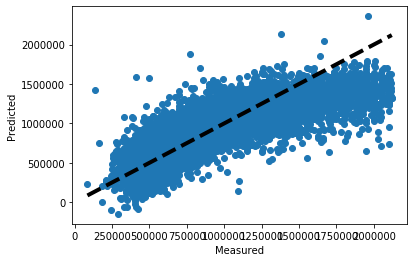

In [100]:
fig, ax = plt.subplots()
ax.scatter(y_test, predict_y_test)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

From the plot we can see there are many observations have larger value than the predicted values from our model.

#### 2. Cross Validation

In [101]:
linreg_cv_pca = LinearRegression()

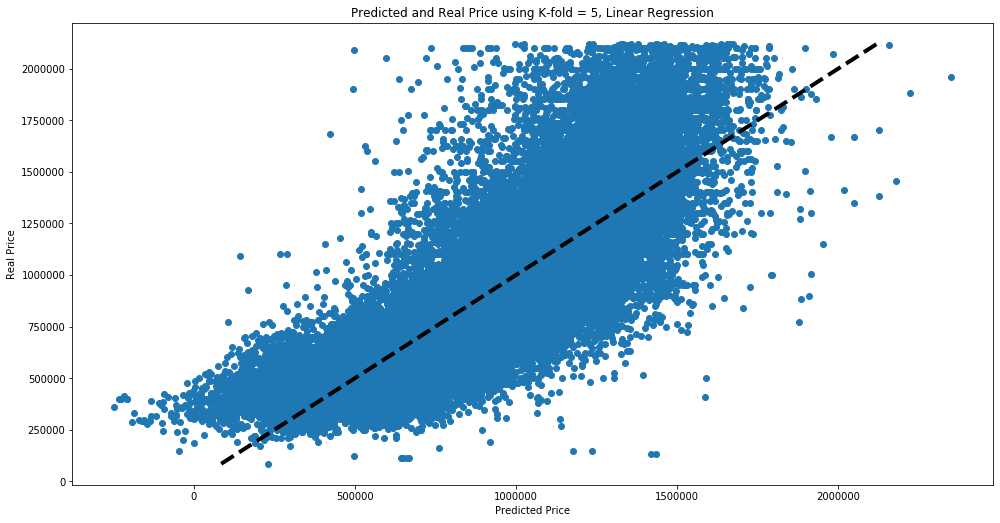

In [102]:
predict_y = cross_val_predict(linreg_cv_pca, X_pca.values, y['Price'].values, cv=5)

fig, ax = plt.subplots()
fig.set_size_inches(16.5, 8.5)
ax.scatter(predict_y,y['Price'])
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_ylabel('Real Price')
ax.set_xlabel('Predicted Price')
plt.title("Predicted and Real Price using K-fold = 5, Linear Regression")
plt.show()

For houses that has price <= 1.5 million, our model can predict with a considerably good price.

But when the price goes beyond 1.5mil, the price predicted is somehow smaller than the expected price

In [103]:
print('CV score: MSE = ', mean_squared_error(y['Price'],predict_y))
print('CV score: R squared = ', r2_score(y['Price'],predict_y))

CV score: MSE =  57568880140.49628
CV score: R squared =  0.6360374989408202


#### 2.1 Visualize the Residuals and test for heteroscedasticity issue

In [104]:
Residuals = predict_y - y['Price']

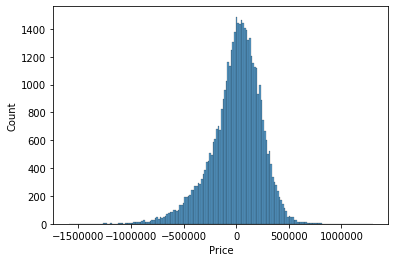

In [105]:
#Plot the residuals using histogram to test for normality

sns.histplot(x = Residuals)

In [106]:
sum(Residuals)

-3303387.989131321

Since Residuals of our model are not normally distributed, we might have to use another algorithm to predict the house price in this dataset

## Conclusion:

- Application of PCA in creating Linear Regression model helps improving performance of the model in the Cross Validation test, but the <b>difference is very minor</b> (from 0.635 to 0.636)


- After using PCA, the total number of features decreased from 63 to 57.
    - And this reducing in number of features might help reduce overfitting.
    - Also number of correlated features might also be reduced, and help reducing the processing time.

In [142]:
def dice3_3(t = 10000000):
    import numpy as np
    prob1 = np.random.rand(1,6)
    prob1 = prob1/np.sum(prob1)
    prob2 = np.random.rand(1,6)
    prob2 = prob2/np.sum(prob2)
    prob3 = np.random.rand(1,6)
    prob3 = prob3/np.sum(prob3)

    d1 = dict(enumerate(prob1.flatten(), 1))
    d2 = dict(enumerate(prob2.flatten(), 1))
    d3 = dict(enumerate(prob3.flatten(), 1))

    result_prob = {}
    total = 0

    for i in d1:
        for j in d2:
            for k in d3:
                total = i+j+k
                if total in result_prob:
                      result_prob[total] += d1[i]*d2[j]*d3[k]
                else:
                      result_prob[total] = d1[i]*d2[j]*d3[k]

    result_times = {}
    for i in result_prob:
        result_times[i] = round(result_prob[i]*t)

    print(d1)
    print(" ")
    print(d2)
    print(" ")
    print(d3)
    print(" ")
    print(result_times)
    print('check total rolling times: {}'.format(sum(result_times.values())))
    print(" ")
    print(result_prob)

print(dice3_3())

{1: 0.13372698571239702, 2: 0.30355538247439884, 3: 0.018402517746988062, 4: 0.18545875528020472, 5: 0.32856907243596317, 6: 0.03028728635004816}
 
{1: 0.24990947676693454, 2: 0.17148566291132367, 3: 0.1581066308542238, 4: 0.27182593265014804, 5: 0.007295021447573492, 6: 0.1413772753697966}
 
{1: 0.09187936338315629, 2: 0.1788149766470464, 3: 0.18143827527493048, 4: 0.253862153075814, 5: 0.04438156050859897, 6: 0.24962367111045397}
 
{3: 30706.0, 4: 150530.0, 5: 308774.0, 6: 526182.0, 7: 830175.0, 8: 1035480.0, 9: 1336186.0, 10: 1338091.0, 11: 1208480.0, 12: 1222026.0, 13: 767970.0, 14: 605352.0, 15: 387382.0, 16: 123569.0, 17: 118408.0, 18: 10689.0}
check total rolling times: 10000000.0
 
{3: 0.003070575342238541, 4: 0.015053027940169793, 5: 0.030877365427434293, 6: 0.052618174472846585, 7: 0.08301754015882229, 8: 0.10354798916831431, 9: 0.13361856641066475, 10: 0.1338091466490534, 11: 0.12084802084060471, 12: 0.12220258878312357, 13: 0.07679700758964836, 14: 0.06053522697117173, 15: 